# Exercise 3: Using Wilks' Theorem
 >__Created__:  15 Mar. 2023 for CLASHEP 23, Harrison B. Prosper

### Introduction 
Consider the 2-parameter statistical model discussed in the lectures:

\begin{align}
    p(D | s, b) & = \textrm{Poisson}(N, s + b) \,\textrm{Poisson}(M, k b),
\end{align}

where $D = N, M$ are the observed data, $N$ is the count in the signal region and $M$ the count in either a background-dominated region or a Monte Carlo simulation of the background. The background estimate in the signal region is $B \pm \delta B = M / k \pm \sqrt{M} / k$. 

### Wilks' Theorem
Given certain conditions, principally that we have enough data and the parameter estimates do not lie on the *boundary* of the $(s, b)$ parameter space, this theorem states that the distribution of the statistic

\begin{align}
    t_\theta(D) & = -  2 \log \left[ \frac{p(D | s, b)}{p(D | \hat{s}, \hat{b})} \right] ,
\end{align}

where $\theta = s, b$ is *approximately* that of a $\chi^2$ variable of 2 degrees of freedom.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### CMS 2014 $H \rightarrow Z Z \rightarrow 4 \ell$ summary data


In [3]:
class Bag:
    pass
bag = Bag()

bag.N = 25
bag.M = 353
bag.k = 37.6
bag.N1= bag.N
bag.M1= bag.M

### Define statistical model and statistic $t_\theta(D)$

For continuous distributions, such as a Gaussian, we refer to the __probability density function (pdf)__ from which a probability can be computed by integrating the pdf over an interval in the space of observations. For discrete distributions, we refer to their functional forms as __probability mass functions (pmf)__. 

In [7]:
def loglikelihood(D, s, b):
    N = D.N
    M = D.M
    k = D.k
    ll  = st.poisson.logpmf(N, s+b)
    ll += st.poisson.logpmf(M, k * b)
    return ll

def logsuplikelihood(D, tiny=1.e-20):
    N = D.N
    M = D.M
    return st.poisson.logpmf(N, N) +  st.poisson.logpmf(M, M)

def statistic(D, s, b):
    return -2*(loglikelihood(D, s, b) - logsuplikelihood(D))

### Find the best-fit values of the parameters

In [8]:
def best_fit(statistic, D):
    
    def nll(params, *args):
        s, b = params
        t, D = args
        return t(D, s, b)
    
    # --------------------
    # find best-fit value
    # --------------------
    guess   = [10.0, 10.0]
    results = op.minimize(nll, guess, args=(statistic, bag), 
                          method='Nelder-Mead')
    return results

In [9]:
results = best_fit(statistic, bag)
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7.224798537208699e-11
             x: [ 1.561e+01  9.388e+00]
           nit: 42
          nfev: 83
 final_simplex: (array([[ 1.561e+01,  9.388e+00],
                       [ 1.561e+01,  9.388e+00],
                       [ 1.561e+01,  9.388e+00]]), array([ 7.225e-11,  8.698e-11,  2.264e-10]))

### Plot confidence sets

In [10]:
def plot_confidence_set(t, D, results=None,
                        xbins=30, xmin=0, xmax=30, 
                        ybins=30, ymin=8, ymax=11,
                        filename='confidence_set.png',
                        fgsize=(5, 5), ftsize=18):
                        
    # make 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$s$', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$b$', fontsize=ftsize)
    
    # compute chi2 levels for 2 degrees of freedom
    # for 0.5sigma, 1sigma etc.
    NDF = 2
    mylevels = np.array([st.chi2.ppf(st.chi2.cdf(0.5, 1), NDF), # chi2 level for 0.5sigma
                         st.chi2.ppf(st.chi2.cdf(1.0, 1), NDF), # chi2 level for 1.0sigma
                         st.chi2.ppf(st.chi2.cdf(1.5, 1), NDF), # etc.
                         st.chi2.ppf(st.chi2.cdf(2.0, 1), NDF)])

    # ----------------------------------------------
    # compute statistic at every grid point
    # then reshape to a 2d array
    # ----------------------------------------------      
    xstep = (xmax - xmin)/xbins
    ystep = (ymax - ymin)/ybins
    
    x     = np.arange(xmin, xmax, xstep) + xstep/2
    y     = np.arange(ymin, ymax, ystep) + ystep/2
    
    X, Y  = np.meshgrid(x, y)
    x     = X.flatten()
    y     = Y.flatten()
    
    N, M  = D.N, D.M
    F     = t(D, x, y).reshape(X.shape)

    # use levels to compute desired contours
    cs = ax.contour(X, Y, F, 
                    extent=(xmin, xmax, ymin, ymax),
                    levels=mylevels, 
                    linewidths=2,
                    cmap='rainbow') 

    # annotate contours
    cs.levels= [r'$0.5\sigma$', 
                r'$1.0\sigma$', 
                r'$1.5\sigma$', 
                r'$2.0\sigma$']
    
    ax.clabel(cs, cs.levels, inline=True, 
              fontsize=18, fmt='%s',  
              colors='black')

    if results:
        if results.success:
            s, b = results.x
            ax.scatter(s, b, s=80, c='black')

            xpos = xmin + 0.1*(xmax-xmin)
            ypos = ymin + 0.9*(ymax-ymin)

            ax.text(xpos, ypos, 
                r'$s: %6.1f$\,\,\,\,$b: %6.1f$' % (s, b), 
                    fontsize=ftsize)

    ax.grid()

    plt.tight_layout()

    if filename != None:
        print('saved to file:', filename)
        plt.savefig(filename)

    plt.show()


saved to file: confidence_set.png


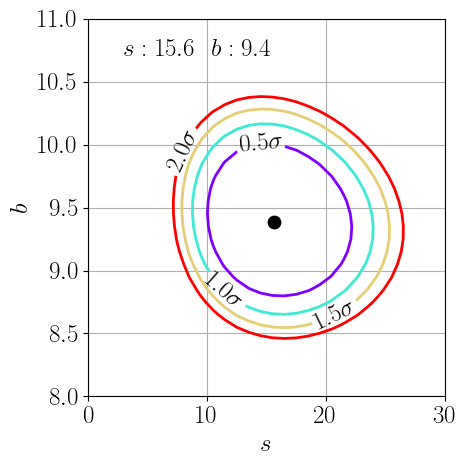

In [11]:
plot_confidence_set(statistic, bag, results)

## Check coverage
Choose a *fixed* parameter point $(s_0, b_0)$.
  1. simulate NEXP experiments
  1. compute statistic $t(D)$ for each experiment
  1. compute $cdf(t(D) = P(\chi^2 < t(D)|s_0, b_0)$
  1. count how often $cdf < CL$
  1. compute coverage

In [16]:
# 0. choose a "true" parameter point
bag.s0 = results.x[0]      # choose as signal mean
bag.b0 = results.x[1]      # choose as background mean
NEXP   = 10000   # number of experiments to simulate

print(f'true s: {bag.s0:6.1f}')
print(f'true b: {bag.b0:6.1f}')

# 1. simulate experiments
N0 = st.poisson.rvs(bag.s0 + bag.b0, size=NEXP)
M0 = st.poisson.rvs(bag.k  * bag.b0, size=NEXP)

# 2. compute statistic for each experiment
bag.N = N0
bag.M = M0
t = statistic(bag, bag.s0, bag.b0)

# 3. compute cdf assuming t is a chi2 variate of 2 degrees of freedom
ndf = 2
cdf = st.chi2.cdf(t, ndf)

# 4. count how often confidence set includes true means
CL  = 0.683
k   = cdf < CL

# 5. compute coverage
coverage = k.sum() / NEXP

print(f'coverage: {coverage:6.3f}')

true s:   15.6
true b:    9.4
coverage:  0.682


In [13]:
def plot_distribution(t, 
                      xbins=60, xmin=0, xmax=15, 
                      ymin=0, ymax=0.5,
                        filename='statistic_distribution.png',
                        fgsize=(5, 5), ftsize=18):
                        
    # make 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$t(D)$', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$p(t)$', fontsize=ftsize)
    
    # compute chi2 level for 2 degrees of freedom
    # for 1sigma
    xstep = (xmax-xmin)/xbins
    x     = np.arange(xmin, xmax+xstep, xstep)
    NDF   = 2
    y     = st.chi2.pdf(x, NDF)

    ax.hist(t, bins=xbins, 
            range=(xmin, xmax), 
            density=True, alpha=0.5, label='simulation')
    
    ax.plot(x, y, color='red', label=r'$p(\chi^2|ndf=2)$')
    ax.legend()
    ax.grid()

    plt.tight_layout()

    plt.savefig(filename)
    
    plt.show()

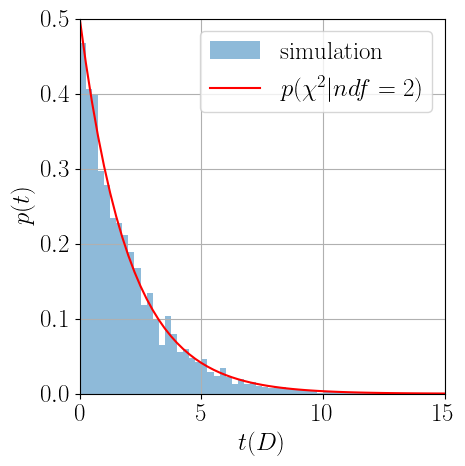

In [14]:
plot_distribution(t)

### Make an animated GIF of confidence sets

In [15]:
def plot_1sigma_confidence_set(t, D, results=None,
                        xbins=30, xmin=0, xmax=30, 
                        ybins=30, ymin=8, ymax=11,
                        filename='confidence_set.png',
                        fgsize=(5, 5), ftsize=18):
                        
    # make 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$s$', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$b$', fontsize=ftsize)
    
    # compute chi2 level for 2 degrees of freedom
    # for 1sigma
    NDF = 2
    mylevels = np.array([st.chi2.ppf(st.chi2.cdf(1.0, 1), NDF)])

    # ----------------------------------------------
    # compute statistic at every grid point
    # then reshape to a 2d array
    # ----------------------------------------------      
    xstep = (xmax - xmin)/xbins
    ystep = (ymax - ymin)/ybins
    
    x     = np.arange(xmin, xmax, xstep) + xstep/2
    y     = np.arange(ymin, ymax, ystep) + ystep/2
    
    X, Y  = np.meshgrid(x, y)
    x     = X.flatten()
    y     = Y.flatten()
    
    N, M  = D.N, D.M
    F     = t(D, x, y).reshape(X.shape)

    # use levels to compute desired contours
    cs = ax.contour(X, Y, F, 
                    extent=(xmin, xmax, ymin, ymax),
                    levels=mylevels, 
                    linewidths=2,
                    cmap='rainbow') 

    # annotate contours
    cs.levels= [r'$1.0\sigma$']

    ax.clabel(cs, cs.levels, inline=True, 
              fontsize=18, fmt='%s',  
              colors='black')

    ax.scatter(D.s0, D.b0, s=80, c='black')

    ax.grid()

    plt.tight_layout()

    plt.savefig(filename)
    
    plt.close() # close file so we don't have too many open at once
    
    #plt.show()

Make a 100 frames.

In [13]:
filenames = []
for i in range(100):
    j = i + 1
    filename = 'f%3.3d.png' % j
    filenames.append(filename)
    
    bag.N = N0[i]
    bag.M = M0[j]
    plot_1sigma_confidence_set(statistic, bag, filename=filename)

Convert to animated GIF.

In [14]:
import imageio.v2 as im

# make gif
with im.get_writer('coverage.gif', mode='I', fps=2) as writer:
    for filename in filenames:
        image = im.imread(filename)
        writer.append_data(image)
        
for filename in filenames:
    os.system(f'rm -f {filename:s}')